# Install and import libraries

In [3]:
!pip install accelerate
!pip install flash_attn einops timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 80.7 MB/s eta 0:00:00
  Created wheel for flash_attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187309225 sha256=237ef9c6157db394e1ddde4ba609a21ebb98382377a27041edc09318801a6f24
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash_attn


In [1]:
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForCausalLM

# Import Florence-2 model

In [3]:
!pip install timm flash_attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 39.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 72.9 MB/s eta 0:00:00
  Created wheel for flash_attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187309225 sha256=237ef9c6157db394e1ddde4ba609a21ebb98382377a27041edc09318801a6f24
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash_attn


In [4]:
model_id = 'microsoft/Florence-2-large'
#model_id = 'microsoft/Florence-2-base'

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)




pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
def florence2(task_prompt,images, text_input=None):
    """
    Calling the Microsoft Florence2 model
    """
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt")

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids,
                                            skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height))

    return parsed_answer


# Object Detection

In [8]:
!unzip data.zip

Archive:  data.zip
   creating: data/
 extracting: data/animal1.jpg        
  inflating: data/b1.jpg             
  inflating: data/b2.jpg             
  inflating: data/r2.jpg             
  inflating: data/r3.jpg             
  inflating: data/y1.jpg             
  inflating: data/y2.jpg             
  inflating: data/y3.jpg             


In [9]:
image = Image.open('/content/data/animal1.jpg')

task_prompt3 = '<OD>'
od_results = florence2(task_prompt3, image)
od_results['<OD>']

{'bboxes': [[118.20000457763672,
   184.6304931640625,
   666.6000366210938,
   717.2954711914062],
  [826.2000122070312,
   360.04949951171875,
   955.800048828125,
   678.8474731445312]],
 'labels': ['elephant', 'person']}

In [10]:
def plot_bbox(image, data):
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

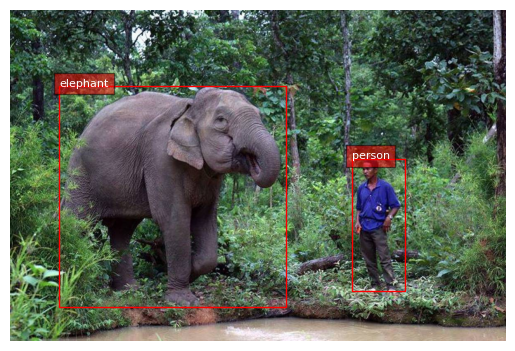

In [11]:
plot_bbox(image, od_results['<OD>']);

# Guided object detection

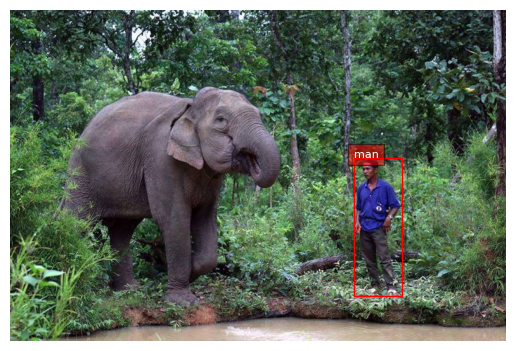

In [12]:
task_prompt4 = "<CAPTION_TO_PHRASE_GROUNDING>"

result = florence2(task_prompt4, image, text_input="man")

plot_bbox(image, result['<CAPTION_TO_PHRASE_GROUNDING>']);

# Auto Data labeling

In [13]:
def florence2(task_prompt, images, text_input=None):
    """
    Calling the Microsoft Florence2 model
    """
    results = []

    for image in images:
        if text_input is None:
            prompt = task_prompt
        else:
            prompt = task_prompt + text_input

        inputs = processor(text=prompt, images=image, return_tensors="pt")

        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            early_stopping=False,
            do_sample=False,
            num_beams=3,
        )
        generated_text = processor.batch_decode(generated_ids,
                                                skip_special_tokens=False)[0]
        parsed_answer = processor.post_process_generation(
            generated_text,
            task=task_prompt,
            image_size=(image.width, image.height))

        results.append(parsed_answer)

    return results



In [14]:
from PIL import Image
import os

def process_images(folder_path):
    # Get all image files in the folder
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    for image_path in image_files:
        image_name = os.path.basename(image_path)
        image_name_without_extension = os.path.splitext(image_name)[0]

        # Load image using PIL
        try:
            image = Image.open(image_path)
        except IOError:
            print(f'Failed to open image: {image_path}')
            continue

        # Define task_prompt3 (if it's constant for all images)
        task_prompt3 = '<OD>'

        # Call your function to get results
        od_results_list = florence2(task_prompt3, [image])

        # Iterate over each result in the list
        for idx, od_results in enumerate(od_results_list):
            # Save results to a text file with the same name as the image
            output_file_path = os.path.join(folder_path, f'{image_name_without_extension}_{idx}.txt')

            with open(output_file_path, 'w') as f:
                # Write the results to the text file
                for key, value in od_results['<OD>'].items():
                    f.write(f"{key}: {value}\n")

            print(f'Results for {image_name} (index {idx}) saved to {output_file_path}')


In [15]:
folder_path = '/content/data'
process_images(folder_path)

Results for y3.jpg (index 0) saved to /content/data/y3_0.txt
Results for b1.jpg (index 0) saved to /content/data/b1_0.txt
Results for y2.jpg (index 0) saved to /content/data/y2_0.txt
Results for r2.jpg (index 0) saved to /content/data/r2_0.txt
Results for b2.jpg (index 0) saved to /content/data/b2_0.txt
Results for animal1.jpg (index 0) saved to /content/data/animal1_0.txt
Results for y1.jpg (index 0) saved to /content/data/y1_0.txt
Results for r3.jpg (index 0) saved to /content/data/r3_0.txt


# Convert to yolo format

In [16]:
import os
import json

def convert_to_yolo_format(bboxes, labels, image_width, image_height):
    yolo_annotations = []

    for bbox, label in zip(bboxes, labels):
        xmin, ymin, xmax, ymax = bbox

        # Calculate bounding box center and dimensions
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        box_width = (xmax - xmin) / image_width
        box_height = (ymax - ymin) / image_height

        # Find the class index (you may need to adjust this based on your class mapping)
        class_index = get_class_index(label)

        # Append annotation in YOLO format
        yolo_annotations.append(f"{class_index} {x_center} {y_center} {box_width} {box_height}")

    return yolo_annotations

def get_class_index(label):
    # Define your class mapping here
    class_mapping = {
        'elephant': 0,
        'person': 1,
        'rose':2
        # Add more classes as needed
    }
    return class_mapping.get(label, -1)  # Return -1 if label not found

def process_images(folder_path):
    # Get all image files in the folder
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    for image_path in image_files:
        image_name = os.path.basename(image_path)
        image_name_without_extension = os.path.splitext(image_name)[0]

        # Load image using PIL
        try:
            image = Image.open(image_path)
            image_width, image_height = image.size
        except IOError:
            print(f'Failed to open image: {image_path}')
            continue

        # Call your function to get annotations
        od_results_list = florence2('<OD>', [image])

        # Iterate over each result in the list
        for idx, od_results in enumerate(od_results_list):
            bboxes = od_results['<OD>']['bboxes']
            labels = od_results['<OD>']['labels']

            # Convert annotations to YOLO format
            yolo_annotations = convert_to_yolo_format(bboxes, labels, image_width, image_height)

            # Save YOLO annotations to a text file
            output_file_path = os.path.join(folder_path, f'{image_name_without_extension}_{idx}.txt')

            with open(output_file_path, 'w') as f:
                for annotation in yolo_annotations:
                    f.write(annotation + '\n')

            print(f'Annotations for {image_name} (index {idx}) saved to {output_file_path}')


In [17]:
folder_path = '/content/data'
process_images(folder_path)

Annotations for y3.jpg (index 0) saved to /content/data/y3_0.txt
Annotations for b1.jpg (index 0) saved to /content/data/b1_0.txt
Annotations for y2.jpg (index 0) saved to /content/data/y2_0.txt
Annotations for r2.jpg (index 0) saved to /content/data/r2_0.txt
Annotations for b2.jpg (index 0) saved to /content/data/b2_0.txt
Annotations for animal1.jpg (index 0) saved to /content/data/animal1_0.txt
Annotations for y1.jpg (index 0) saved to /content/data/y1_0.txt
Annotations for r3.jpg (index 0) saved to /content/data/r3_0.txt
